In [3]:
import numpy as np
from scipy.special import ellipk, ellipe


# TODO - there is a divergent case mentioned in the paper - implement the fix (if it already in there)
def babic_M(Rp, Rs, pc, n, tol=1e-13):
    '''
    Calcualte the mutual inductance M.

    Keyword arguments:
    Rp  -- radius of primary (transmitting) loop
    Rs  -- radius of secondary (receiving) loop, requires Rp >= Rs
    pc  -- numpy.array() vector [x, y, z] between centers of loops
    n   -- numpy.array() vector [x, y, z] normal to rx loop
    tol -- absolute tolerance, default 1e-13
    '''

    def f24(p, h, e, g, d, a, b, c):
        '''
        idk
        p - vector
        h - number
        e - number
        g - number
        d - number
        a - number
        b - number
        c - number
        '''

        h2, e2, g2, a2, b2, c2 = h*h, e*e, g*g, a*a, b*b, c*c
        l2 = a*a+c2
        l = np.sqrt(l2)
        L2 = l2+b*b
        L = np.sqrt(L2)
        l2L2 = L2*l2
        lL = l*L

        sp = np.sin(p)
        cp = np.cos(p)
        cp2 = cp*cp
        sp2 = sp*sp

        if l == 0:
            p1, p2, p3, p4, p5 = 0, -g*np.sign(b), 0, -e*np.sign(b), d
            V = np.sqrt(e2 + g2 + h2*cp2 - 2*h*e*np.sign(b)*cp)
        else:
            p1, p2, p3, p4, p5 = g*c/l, -(e*l2 + g*a*b)/lL, h*c/L, (g*l2 - e*a*b - d*b*c)/lL, (d*a - e*c)/l
            V = np.sqrt( (e2 + g2) + h2*( (1 - b2*c2/l2L2)*cp2 + c2/l2*sp2 + a*b*c/(l2*L)*np.sin(2*p) ) - 2*h/lL*(e*a*b - g*l2)*cp - 2*h*e*c/l*sp )

        A = (1 + e2 + g2 + h2 + d*d) + 2*h*(p4*cp + p5*sp)
        m = 4*V/(A + 2*V)
        k = np.sqrt(m)
        K, E = ellipk(m), ellipe(m)
        PSI = (1 - 0.5*m)*K - E
        f = (p1*cp + p2*sp + p3)*PSI/(k*V**1.5)
        return f


    xc, yc, zc = pc[0], pc[1], pc[2]
    a, b, c = n[0], n[1], n[2]

    alpha, beta, gamma, delta = Rs/Rp, xc/Rp, yc/Rp, zc/Rp

    decdigs = int(np.abs(np.floor(np.log10(tol))))
    rom = np.zeros((2, decdigs))
    romall = np.zeros((1, 2**(decdigs-1) + 1))
    step = 2*np.pi/2**(decdigs-1)
    romall = f24(np.arange(0, 2*np.pi + 0.1*step, step), alpha, beta, gamma, delta, a, b, c)
    h = 2 * np.pi
    rom[0, 0] = h*(romall[0] + romall[-1])/2

    for i in range(2, decdigs + 1):
        step = 2**(decdigs - i + 1)
        # trapezoidal approximations
        indicies = [int(ind) for ind in np.arange((step/2) + 1, 2**(decdigs-1) + 0.1*step, step) - 1]
        rom[1, 0] = (rom[0, 0] + h*np.sum(romall[indicies]))/2
        # Richardson extrapolation
        for k in range(1, i):
            rom[1, k] = ((4**k)*rom[1, k - 1] - rom[0, k - 1])/((4**k) - 1)

        rom[0, 0:i] = rom[1, 0:i]
        h = h / 2

    M = 4e-7 * Rs * rom[0, decdigs - 1]
    return M


C:\Users\jaden\AppData\Local\Temp\ipykernel_8536\4112310018.py:56: RuntimeWarning: invalid value encountered in true_divide
  f = (p1*cp + p2*sp + p3)*PSI/(k*V**1.5)
C:\Users\jaden\AppData\Local\Temp\ipykernel_8536\4112310018.py:80: RuntimeWarning: invalid value encountered in double_scalars
  rom[1, k] = ((4**k)*rom[1, k - 1] - rom[0, k - 1])/((4**k) - 1)


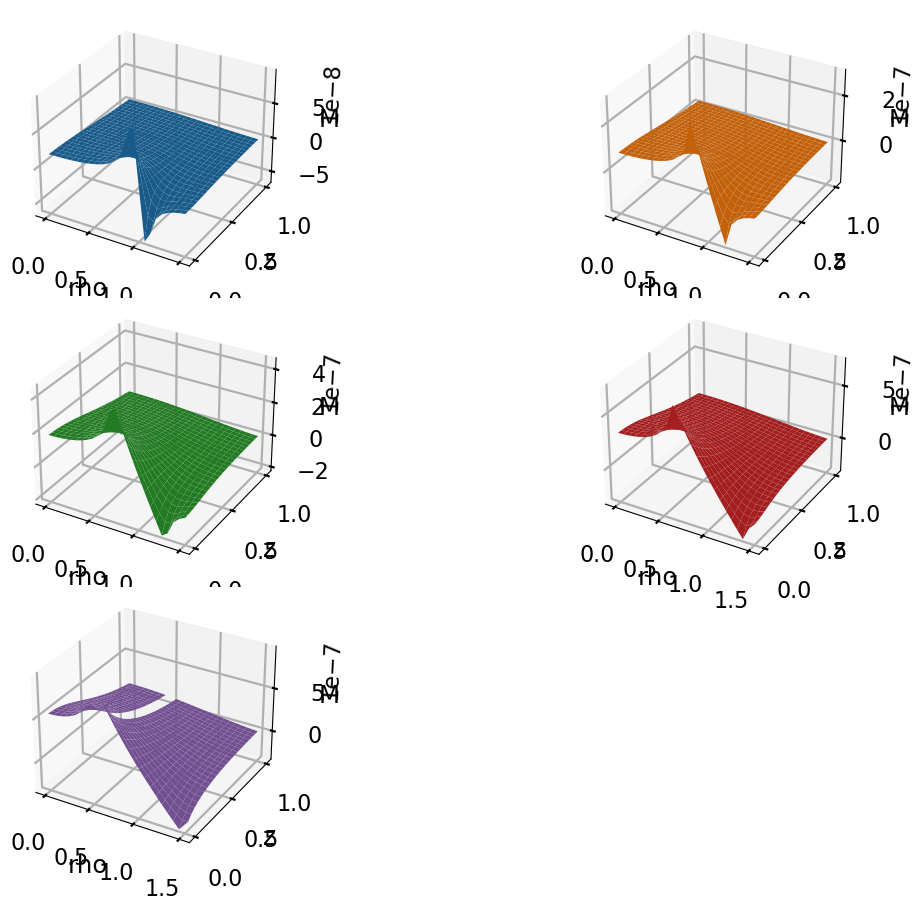

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

num_grid = 25

R_tx = 1
R_rx = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
z_range = np.linspace(0, 1, num=num_grid)
rho_range = np.linspace(0, 1.5, num=num_grid)

M = {} # {R_rx:[], ...}

for r in R_rx:
    RHO, Z = np.meshgrid(rho_range, z_range)
    M[r] = np.array([babic_M(R_tx, r, np.array([rho, 0, z]), np.array([0, 0, 1])) for rho, z in zip(np.ravel(RHO), np.ravel(Z))]).reshape(RHO.shape)

'''
fig, axs = plt.subplots(len(R_rx))
for ax, Mr in zip(axs, M):
    ax.plot_surface(RHO, Z, Mr)
'''

fig = plt.figure()
ax = fig.add_subplot(321, projection='3d')
ax.plot_surface(RHO, Z, M[0.1], color="tab:blue")
ax.set_xlabel("rho")
ax.set_ylabel("z")
ax.set_zlabel("M")
#ax.set_title("R_rx = 0.1")

ax = fig.add_subplot(322, projection='3d')
ax.plot_surface(RHO, Z, M[0.2], color="tab:orange")
ax.set_xlabel("rho")
ax.set_ylabel("z")
ax.set_zlabel("M")
#ax.set_title("R_rx = 0.2")

ax = fig.add_subplot(323, projection='3d')
ax.plot_surface(RHO, Z, M[0.3], color="tab:green")
ax.set_xlabel("rho")
ax.set_ylabel("z")
ax.set_zlabel("M")
#ax.set_title("R_rx = 0.3")

ax = fig.add_subplot(324, projection='3d')
ax.plot_surface(RHO, Z, M[0.4], color="tab:red")
ax.set_xlabel("rho")
ax.set_ylabel("z")
ax.set_zlabel("M")
#ax.set_title("R_rx = 0.4")

ax = fig.add_subplot(325, projection='3d')
ax.plot_surface(RHO, Z, M[0.5], color="tab:purple")
ax.set_xlabel("rho")
ax.set_ylabel("z")
ax.set_zlabel("M")
#ax.set_title("R_rx = 0.5")

fig.tight_layout()

In [37]:
a = M[0.1]

print(np.nanmax(a.flatten()))

9.475978161400388e-08
